# Development of wavelet, entropy, and zero crossings functions

In [2]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from collections import Counter
import time
import pywt
#from nptdms import TdmsFile #Process raw ramping file


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


## 0. Starting functions

In [46]:
#Loading data function
def load_channel_and_time(dir_path, channel):
    """Loading a channel from a directory and return a pandas data frame with two columns, channle and time"""
    
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    
    return data_frame


#Plot a single channel, used by next function
def plot_channel(data, channel, time_range = None):
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #plot
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data[channel])
    plt.xlabel("Time (s)")
    plt.ylabel("Volt")
    plt.title("Variable {}".format(channel))
    plt.show()
    
    %reset -f in

#Plotting data function
def load_and_plot(dir_path, channel, time_range = None):
    """Load a particular channel from a quench, and then plot it.  
    """
    ai = load_channel_and_time(dir_path, channel)
    
    plot_channel(ai, channel, time_range = time_range)
    
    #Just for dumping data from RAM on the server, needed when processing larger amount of data
    #don't need to worry about this for now. 
    %reset -f in
    
#Spectrogram plotting function
def plot_spectrogram(dir_path, channel, time_range, window = 1500, step = 10, window_type = 'hanning'):
    
    #Select appropriate time segment
    data = load_channel_and_time(dir_path, channel)

    start = time_range[0]
    end = time_range[1]

    data = data[(data["time"] > start) & (data["time"] < end)]


    from scipy import signal
    
    #FFT
    freqs, times, Sx = signal.spectrogram(data[channel], fs=100000, window= window_type,
                                      nperseg=window, noverlap= window - step,
                                      detrend=False, scaling='spectrum')
    
    #Dump data from RAM
    %reset -f in
    
    #Plot!
    f, ax = plt.subplots(figsize=(20,2))
    ax.pcolormesh(times, freqs / 1000, 10 * np.log10(Sx), cmap='viridis')
    ax.set_title("Spectrogram of sensor {}".format(channel))
    ax.set_ylabel('Frequency [kHz]')
    ax.set_xlabel('Time [s]');

## 1. Development

### 1.1 Zero crossings

In [7]:
def zero_crossings(list_values):
    
    zero_crossing_indices = np.where(np.diff(np.sign(list_values)))[0]
    num_zero_crossings = len(zero_crossing_indices)
    
    return num_zero_crossings

def calculate_zero_crossings(dir_path, channel, time_range = None):
    
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    return zero_crossings(data[channel].to_numpy())

def plot_zero_crossings(dir_path, channel, time_range = None, window = 2000):
    
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Variance
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data.loc[:, channel].rolling(window=window).apply(zero_crossings),
             label = "Number of zero-crossings",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Zero crossings".format(channel))
    plt.show()
    
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time(dir_path, time_range = None):
    
    tdata = np.load(dir_path + "time.npy")
    
    start = min(tdata)
    end = max(tdata)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    tdata = tdata[(tdata > start) & (tdata < end)]
   
    %reset -f in
    
    return tdata
    
    
def plot_zero_crossings_product(dir_path, time_range = None, window = 2000, step = 100):
    
    time_axis = load_time(dir_path, time_range)[window-1::step]
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, product)
    plt.xlabel("Time (s)")
    plt.title("Product of zero_crossings.")

    
    

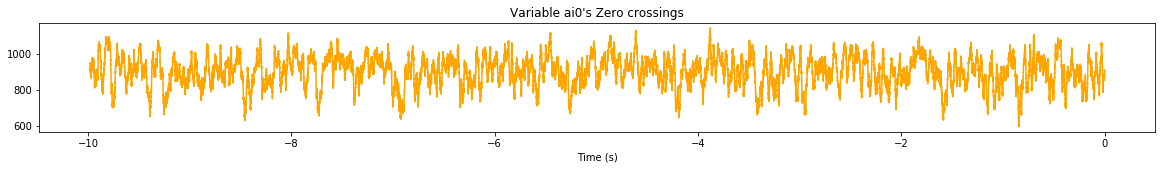

In [34]:
plot_zero_crossings("./data/Ramp22/", "ai0", time_range = (-10, 0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


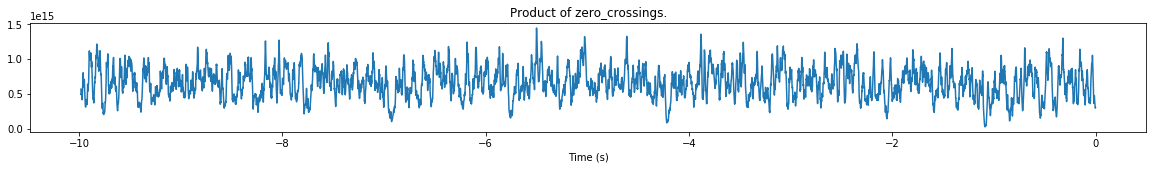

In [4]:
plot_zero_crossings_product("./data/Ramp22/", time_range = (-10, 0))

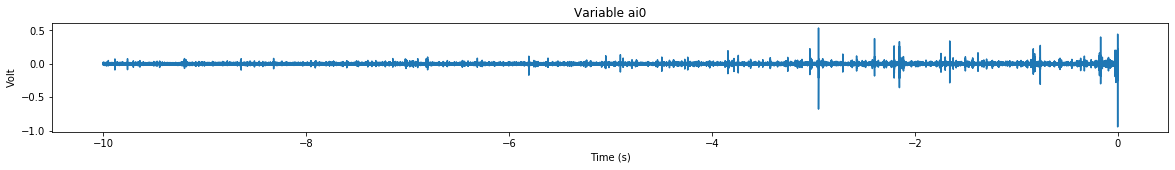

Flushing input history
Flushing input history


In [8]:
load_and_plot("./data/Ramp4/", "ai0", time_range = (-10, 0))

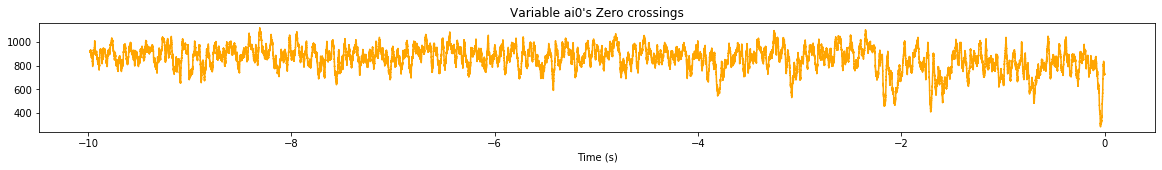

In [7]:
plot_zero_crossings("./data/Ramp4/", "ai0", time_range = (-10, 0))

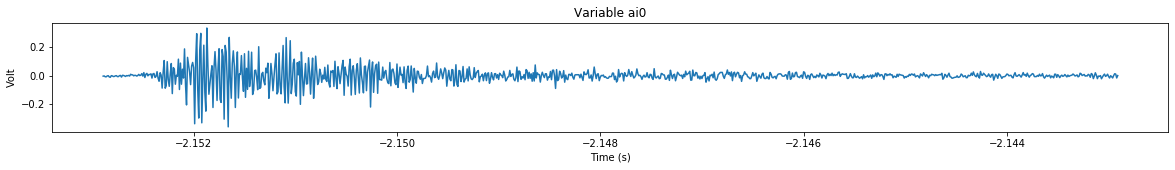

Flushing input history
Flushing input history


In [38]:
load_and_plot("./data/Ramp4/", "ai0", time_range = (-2.1529, -2.1529 + 10e-3))

In [39]:
test_zero_crossings("./data/Ramp4/", "ai0", time_range = (-2.1529, -2.1529 + 10e-3))

500

In [40]:
test_zero_crossings("./data/Ramp4/", "ai0", time_range = (-100, -100 + 10e-3))

569

In [43]:
test_zero_crossings("./data/Ramp4/", "ai0", time_range = (-20, -20 + 10e-3))

449

In [44]:
test_zero_crossings("./data/Ramp4/", "ai0", time_range = (-5, -5 + 10e-3))

445

In [46]:
test_zero_crossings("./data/Ramp4/", "ai0", time_range = (-3, -3 + 10e-3))

402

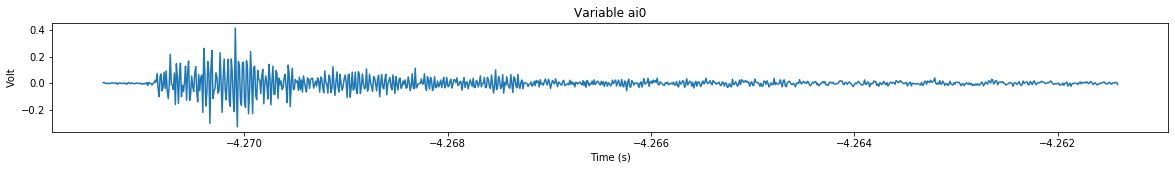

Flushing input history
Flushing input history


In [41]:
load_and_plot("./data/Ramp5/", "ai0", time_range = (-4.2714, -4.2714 + 10e-3))

In [42]:
test_zero_crossings("./data/Ramp5/", "ai0", time_range = (-4.2714, -4.2714 + 10e-3))

493

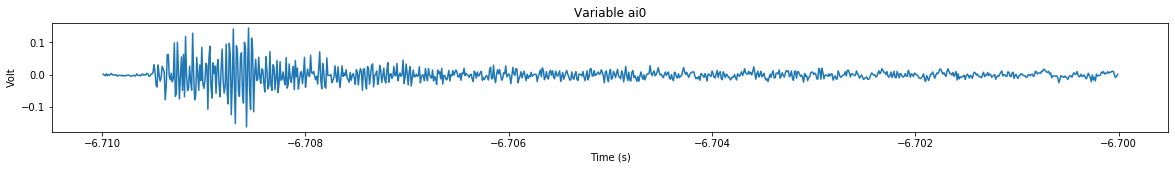

Flushing input history
Flushing input history


In [54]:
load_and_plot("./data/Ramp28/", "ai0", time_range = (-6.71, -6.71 + 10e-3 ))

In [56]:
calculate_zero_crossings("./data/Ramp28/", "ai0", time_range = (-6.71, -6.71 + 10e-3 ))

454

In [11]:
def get_entropy(list_values):
    list_values = np.asarray(list_values)
    counter_values = Counter(list_values).most_common()
    probabilities = [elem[1]/len(list_values) for elem in counter_values]
    entropy=scipy.stats.entropy(probabilities)
    return entropy

In [9]:
def plot_entropy(dir_path, channel, time_range = None, window = 2000):
    
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Variance
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data.loc[:, channel].rolling(window=window).apply(get_entropy),
             label = "Moving Entropy",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Moving Entropy".format(channel))
    plt.show()

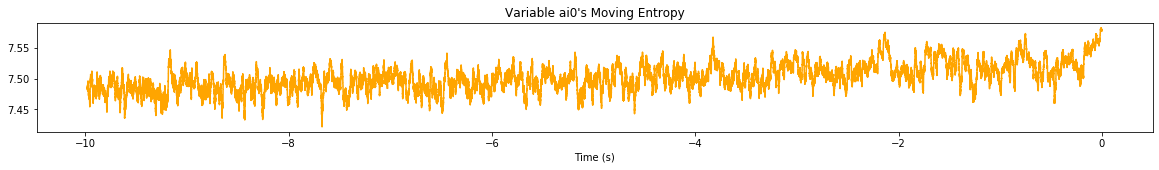

1646.1822583675385


In [14]:
start = time.time()
plot_entropy("./data/Ramp4/", "ai0", time_range = (-10, 0))
end = time.time()
print(end - start)

In [18]:
def get_rms(data):
    data = np.asarray(data)
    return np.nanmean(np.sqrt(data**2))

def plot_rms(dir_path, channel, time_range = None, window = 2000):
    
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Variance
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data.loc[:, channel].rolling(window=window).apply(get_rms),
             label = "Moving RMS",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Moving RMS".format(channel))
    plt.show()

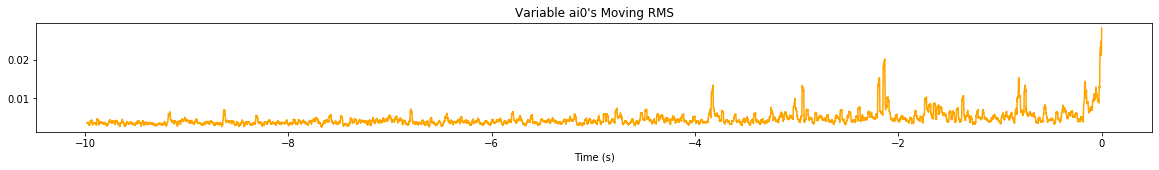

295.40206027030945


In [19]:
start = time.time()
plot_rms("./data/Ramp4/", "ai0", time_range = (-10, 0))
end = time.time()
print(end - start)

## 1.2 Wavelet plotting

Flushing input history


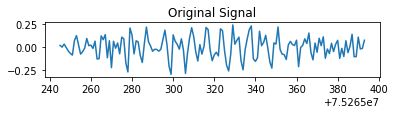

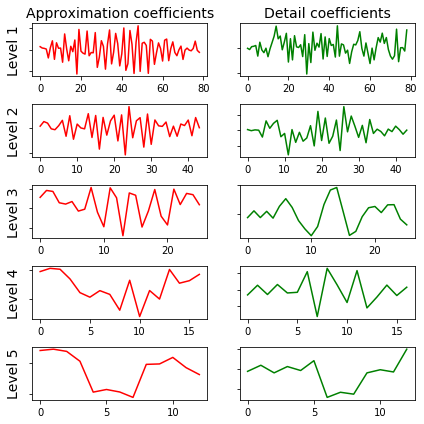

In [6]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time(dir_path, time_range = None):
    
    tdata = np.load(dir_path + "time.npy")
    
    start = min(tdata)
    end = max(tdata)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    tdata = tdata[(tdata > start) & (tdata < end)]
   
    %reset -f in
    
    return tdata

import pywt

#Load time and data
chirp_signal = load_sensor("./data/Ramp4/", "ai2", time_range= (-2.1525, -2.1525 + 1.5e-3))
x = np.linspace(0, 1, num=len(chirp_signal))
    
fig, ax = plt.subplots(figsize=(6,1))
ax.set_title("Original Signal")
ax.plot(chirp_signal)
plt.show()
    
data = chirp_signal
waveletname = 'sym5'

#Initialize plot grid
fig, axarr = plt.subplots(nrows=5, ncols=2, figsize=(6,6))

#Wavelet transform for different levels
for ii in range(5):
    
    #Obtain approximation coefficients and detail coefficients
    (data, coeff_d) = pywt.dwt(data, waveletname)
    axarr[ii, 0].plot(data, 'r')
    axarr[ii, 1].plot(coeff_d, 'g')
    
    
    axarr[ii, 0].set_ylabel("Level {}".format(ii + 1), fontsize=14, rotation=90)
    axarr[ii, 0].set_yticklabels([])
    
    #Set label for first set of plot
    if ii == 0:
        axarr[ii, 0].set_title("Approximation coefficients", fontsize=14)
        axarr[ii, 1].set_title("Detail coefficients", fontsize=14)
        
    axarr[ii, 1].set_yticklabels([])
    
#Additional formatting
plt.tight_layout()
plt.show()

In [ ]:
help(pywt.cwt)

Flushing input history
Flushing input history


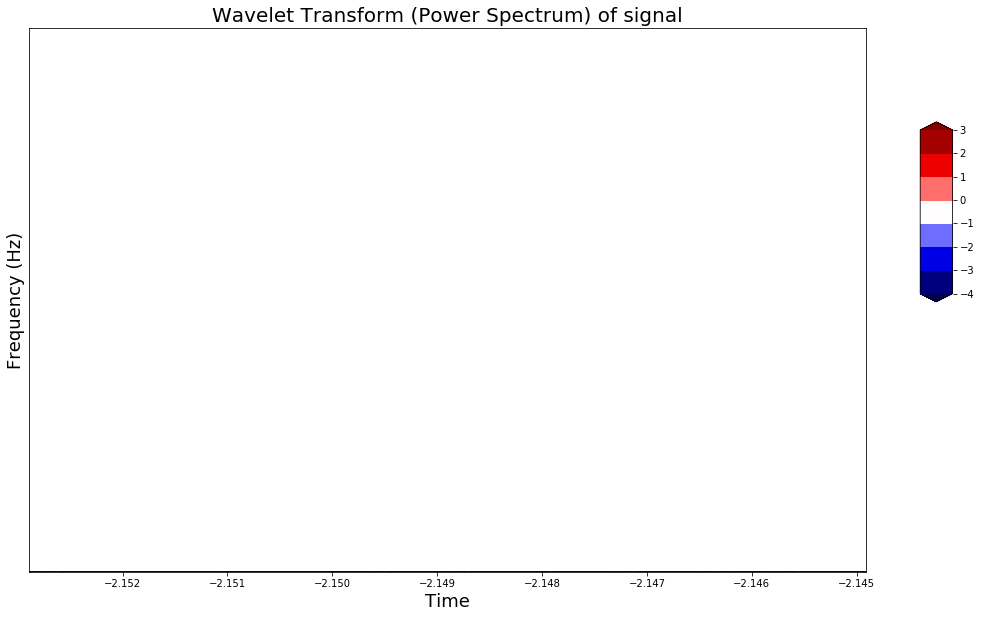

In [11]:
def plot_wavelet(time, signal, scales, 
                 waveletname = 'cmor', 
                 cmap = plt.cm.seismic, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Frequency (Hz)', 
                 xlabel = 'Time'):
    
    #Wavelet transform
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, sampling_period = 100000)
    power = (abs(coefficients)) ** 2
    levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
    contourlevels = np.log2(levels)
    
    #Plot contour
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(frequencies), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    #Formatting of plot
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(frequencies.min())), np.ceil(np.log2(frequencies.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()
    
time_axis = load_time("./data/Ramp4/", time_range = (-2.1529, -2.1529 + 8e-3))
signal = load_sensor("./data/Ramp4/", "ai2", time_range = (-2.1529, -2.1529 + 8e-3))
scales = np.arange(5000, 10000)

plot_wavelet(time_axis, signal, scales)

In [12]:
#using Obspy

In [4]:
help(cwt)

Help on function cwt in module obspy.signal.tf_misfit:

cwt(st, dt, w0, fmin, fmax, nf=100, wl='morlet')
    Continuous Wavelet Transformation in the Frequency Domain.
    
    .. seealso:: [Kristekova2006]_, eq. (4)
    
    :param st: time dependent signal.
    :param dt: time step between two samples in st (in seconds)
    :param w0: parameter for the wavelet, tradeoff between time and frequency
        resolution
    :param fmin: minimum frequency (in Hz)
    :param fmax: maximum frequency (in Hz)
    :param nf: number of logarithmically spaced frequencies between fmin and
        fmax
    :param wl: wavelet to use, for now only 'morlet' is implemented
    
    :return: time frequency representation of st, type numpy.ndarray of complex
        values, shape = (nf, len(st)).



In [49]:
time_axis = load_time("./data/Ramp4/", time_range = (-2.1529, -2.1529 + 8e-3))
signal = load_sensor("./data/Ramp4/", "ai2", time_range = (-2.1529, -2.1529 + 8e-3))
dt = 1./100000
f_min = 10000
f_max = 50000

Flushing input history
Flushing input history


In [82]:
f_min = 1
f_max = 50000

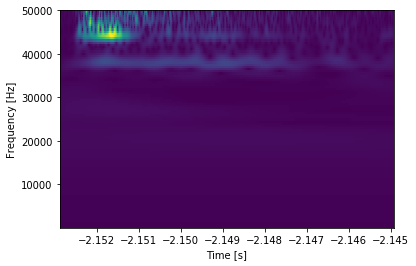

In [83]:
scalogram = cwt(signal, dt, 4, f_min, f_max)

fig = plt.figure()
ax = fig.add_subplot(111)

x, y = np.meshgrid(
    time_axis,
    np.linspace(f_min, f_max, scalogram.shape[0]))

ax.pcolormesh(x, y, np.abs(scalogram), cmap=obspy_sequential)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Frequency [Hz]")
ax.set_ylim(f_min, f_max)
plt.show()

In [40]:
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

def plot_scalogram(dir_path, sensor, time_range, w0 = 6, f_min = 1, f_max = 50000):
    
    dt = 1./100000
    
    time_axis = load_time(dir_path, time_range)
    signal = load_sensor(dir_path, sensor, time_range)
    
    scalogram = cwt(signal, dt, w0, f_min, f_max)
    
    fig = plt.figure(figsize=(20,2))
    ax = fig.add_subplot(111)

    x, y = np.meshgrid(
        time_axis,
        np.linspace(f_min/1000, f_max/1000, scalogram.shape[0]))

    ax.pcolormesh(x, y, 10 * np.log10(np.abs(scalogram)), cmap=obspy_sequential)
    ax.set_xlabel("Time [s]")
    ax.set_ylabel("Frequency [kHz]")
    #ax.set_yscale('log')
    ax.set_ylim(f_min/1000, f_max/1000)
    plt.show()

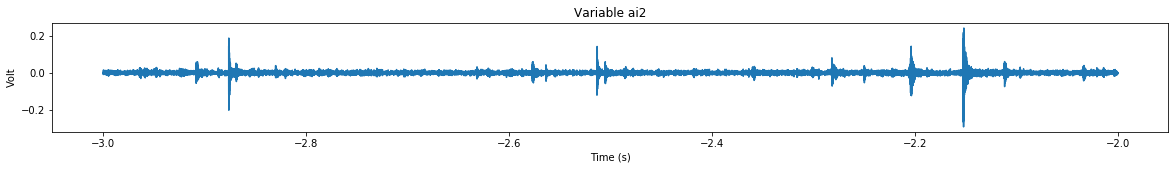

Flushing input history
Flushing input history


In [48]:
load_and_plot("./data/Ramp4/", "ai2", (-3, -2))

Flushing input history
Flushing input history


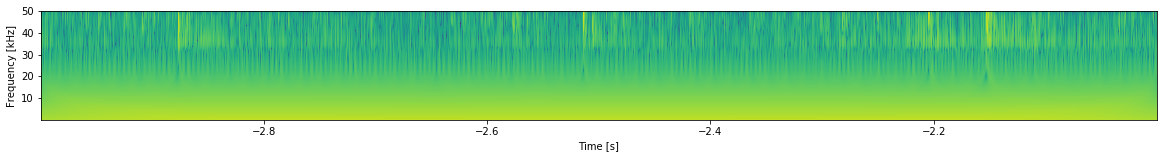

In [49]:
plot_scalogram("./data/Ramp4/", "ai2", (-3, -2), w0 = 1)

## 1.3 FFT plot values

In [25]:
def imgFFT_mean(data):
    
    data = np.asarray(data)
    
    #Take both the imaginary and the real part of the Fourier transform in each window
    zc = np.fft.fft(data)

    #FFT transform values
    #realFFT = np.real(zc)
    imgFFT = np.imag(zc)
    
    return imgFFT.mean()

def plot_FFT(dir_path, channel, time_range = None, window = 2000):
    
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Variance
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data.loc[:, channel].rolling(window=window).apply(imgFFT_mean),
             label = "Moving imgFFT_mean",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Moving imgFFT_mean".format(channel))
    plt.show()

## 1.4 RMS calculation

In [13]:
def rms(data):
    return np.nanmean(np.sqrt(data**2))

def plot_rms(dir_path, channel, time_range = None, window = 2000):
    
    data = load_channel_and_time(dir_path, channel)
    
    #Take data within the time range
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    #Variance
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data.loc[:, channel].rolling(window=window).apply(rms, raw = True),
             label = "Moving RMS",
             color = 'orange')
    plt.xlabel("Time (s)")
    plt.title("Variable {}'s Moving RMS".format(channel))
    plt.show()

def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time(dir_path, time_range = None):
    
    tdata = np.load(dir_path + "time.npy")
    
    start = min(tdata)
    end = max(tdata)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    tdata = tdata[(tdata > start) & (tdata < end)]
   
    %reset -f in
    
    return tdata
    
    
def plot_rms_product(dir_path, time_range = None, window = 2000, step = 10):
    
    time_axis = load_time(dir_path, time_range)[window-1::step]
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(rms, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Plot
    plt.figure(figsize=(20,2))
    plt.plot(time_axis, product)
    plt.xlabel("Time (s)")
    plt.title("Product of R.M.S.")

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
913.0777409076691


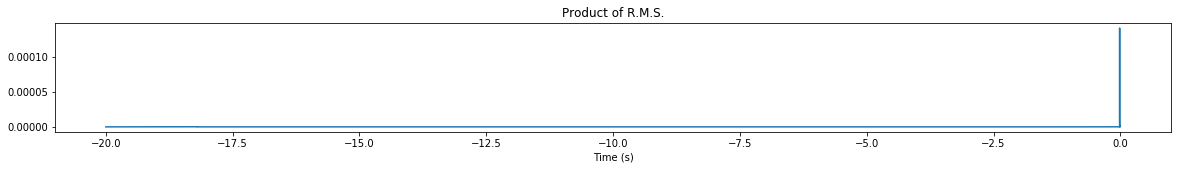

In [14]:
start = time.time()
plot_rms_product("./data/Ramp22/", time_range = (-20, 0), window = 200)
end = time.time()
print(end - start)